# Plotting DVL and Slocum Glider Data with Pandas & Seaborn

---
## Import Libraries

In [26]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import seaborn as sns 
import struct
import sys
import utm
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)

---
## Load or Parse DVL data 

In [27]:
reload_modules()
glider = "sentinel"
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)
filename = "01820002.pd0" # example of prime data set to work with
# filename = "01740000.pd0" # example of file not parsing correctly
# filename = "sk261222.pd0" # example of another cool mission (less bottom track, long dive)
ts2 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename, save=False)

________________________________________
- Parsing DVL File ---------------------
    input file: 01820002.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
- Parsing Complete ---------------------
    # ensembles:   2410
    parsing time:  20.537898
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords


---
## Load or Parse Slocum Glider data 

In [28]:
reload_modules()
directory = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


In [4]:
ts_flight_kolumbo_all.df

,time,m_filename_hash,m_mission_hash,m_present_time,m_speed,m_pitch,m_roll,m_heading,m_fin,m_depth,...,m_water_vx,m_water_vy,m_vx_lmc,m_vy_lmc,m_final_water_vx,m_final_water_vy,m_appear_to_be_at_surface,m_science_clothesline_lag,sci_m_present_time,x_software_ver
2019-11-21 10:10:53.978060,1.574349e+09,-3.711043e+18,7.637063e+18,1.574331e+09,0.0,-0.010472,0.092503,3.87812,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,1.01410,1.574331e+09,8.2
2019-11-21 10:11:08.123960,1.574349e+09,-3.711043e+18,7.637063e+18,1.574331e+09,NaN,-0.010472,0.092503,3.87812,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.87073,1.574331e+09,NaN
2019-11-21 10:11:12.365940,1.574349e+09,-3.711043e+18,7.637063e+18,1.574331e+09,NaN,-0.010472,0.092503,3.87812,0.0,NaN,...,NaN,NaN,-0.013996,0.205301,NaN,NaN,1.0,2.11313,1.574331e+09,NaN
2019-11-21 10:11:16.895690,1.574349e+09,-3.711043e+18,7.637063e+18,1.574331e+09,NaN,-0.010472,0.092503,3.87812,0.0,0.0,...,NaN,NaN,-0.013996,0.205301,NaN,NaN,1.0,2.63840,1.574331e+09,NaN
2019-11-21 10:11:21.434270,1.574349e+09,-3.711043e+18,7.637063e+18,1.574331e+09,NaN,-0.010472,0.092503,3.87812,0.0,0.0,...,NaN,NaN,-0.013996,0.205301,NaN,NaN,1.0,4.69412,1.574331e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-26 15:24:04.092740,1.574800e+09,-1.766316e+17,5.049151e+18,1.574782e+09,NaN,-0.085521,0.200713,3.73326,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.96167,1.574782e+09,NaN
2019-11-26 15:24:08.338320,1.574800e+09,-1.766316e+17,5.049151e+18,1.574782e+09,NaN,-0.061087,0.249582,3.78736,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.19501,1.574782e+09,NaN
2019-11-26 15:24:12.755490,1.574800e+09,-1.766316e+17,5.049151e+18,1.574782e+09,NaN,-0.073304,0.160570,3.88859,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.61676,1.574782e+09,NaN
2019-11-26 15:24:17.006290,1.574800e+09,-1.766316e+17,5.049151e+18,1.574782e+09,NaN,-0.064577,0.197222,3.91303,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.88104,1.574782e+09,NaN


In [5]:
ts_flight_kolumbo_all.df.to_csv("/Users/zduguid/Desktop/Kolumbo-glider-flight-computer.csv")

---
## Combine DVL data with Flight Controller and convert to UTM

sk222256.CSV -------------------------
    # dbd ensembles:  1807
        # dbd files:  2
         # missions:  1
   input <lat, lon>: <3631.04, 2528.44>
     UTM <  E,   N>: <363357.45, 4042419.33, zone=35>


sk261222.CSV -------------------------
    # dbd ensembles:  2549
        # dbd files:  1
         # missions:  1
   input <lat, lon>: <3631.76, 2529.07>
     UTM <  E,   N>: <364321.93, 4043736.76, zone=35>


01820013.CSV -------------------------
    # dbd ensembles:  635
        # dbd files:  1
         # missions:  1
   input <lat, lon>: <3630.87, 2528.31>
     UTM <  E,   N>: <363161.35, 4042103.23, zone=35>


01820010.CSV -------------------------
    # dbd ensembles:  281
        # dbd files:  2
         # missions:  1
   input <lat, lon>: <3630.88, 2528.35>
     UTM <  E,   N>: <363220.73, 4042119.31, zone=35>


sk211610.CSV -------------------------
    # dbd ensembles:  255
        # dbd files:  1
         # missions:  1
   input <lat, lon>: <3631.22, 2528.49>
     UTM 

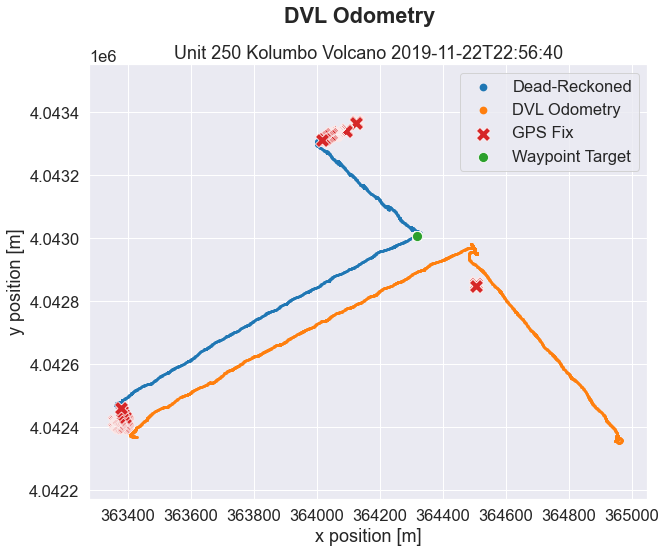

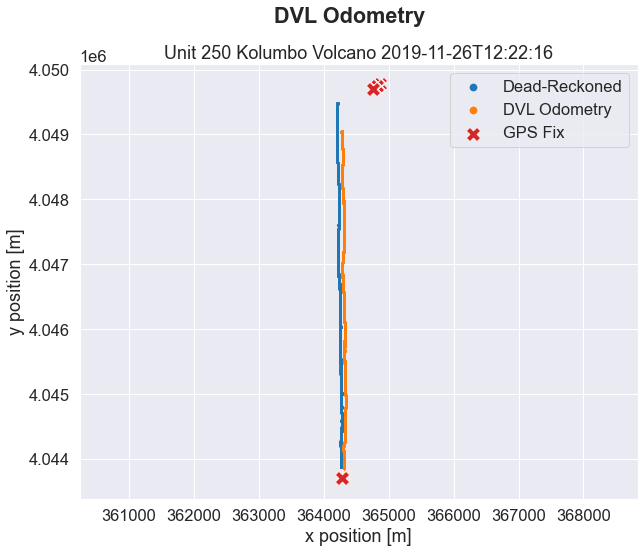

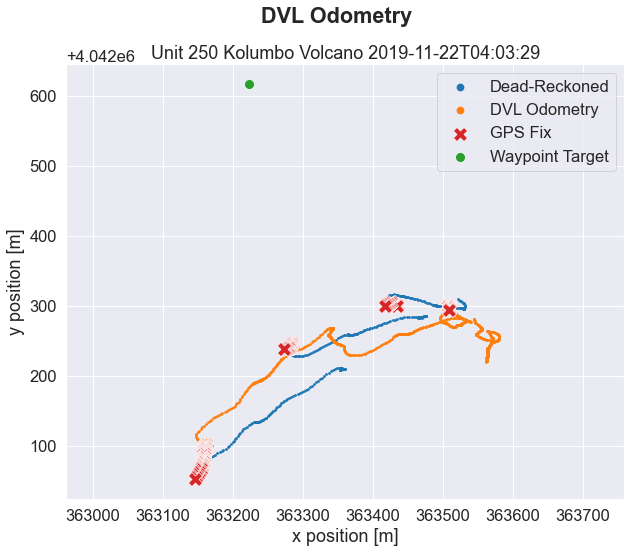

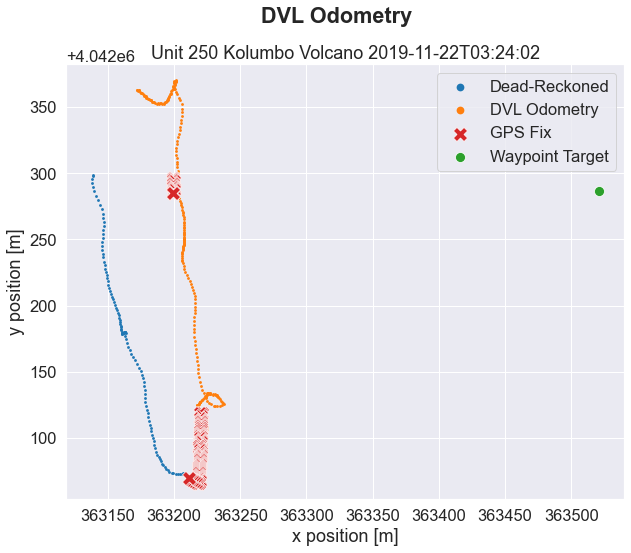

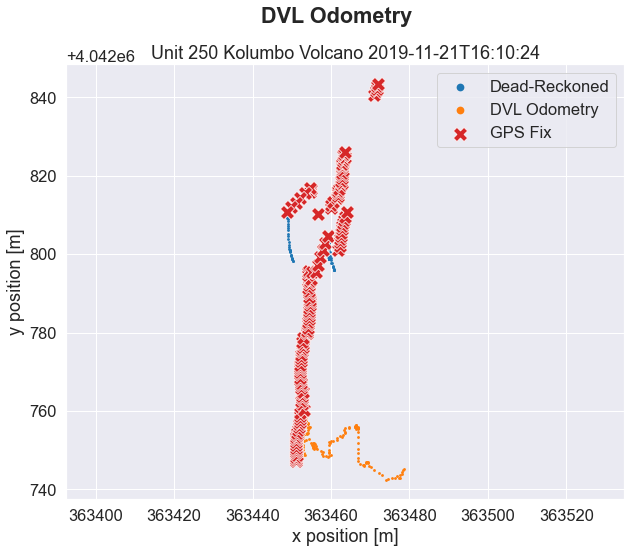

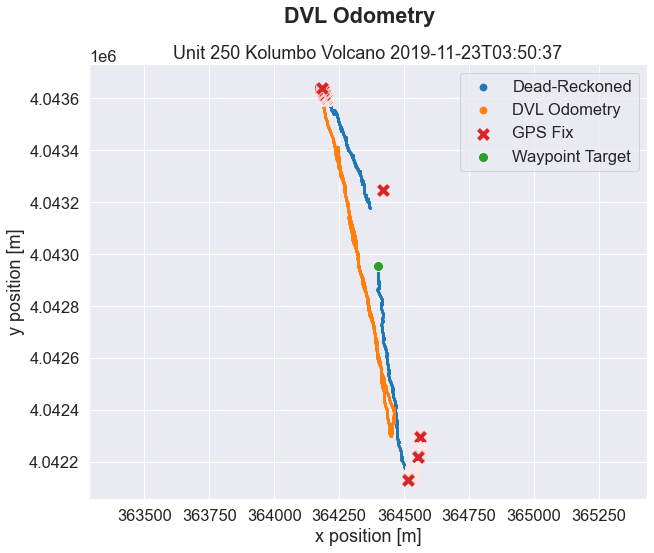

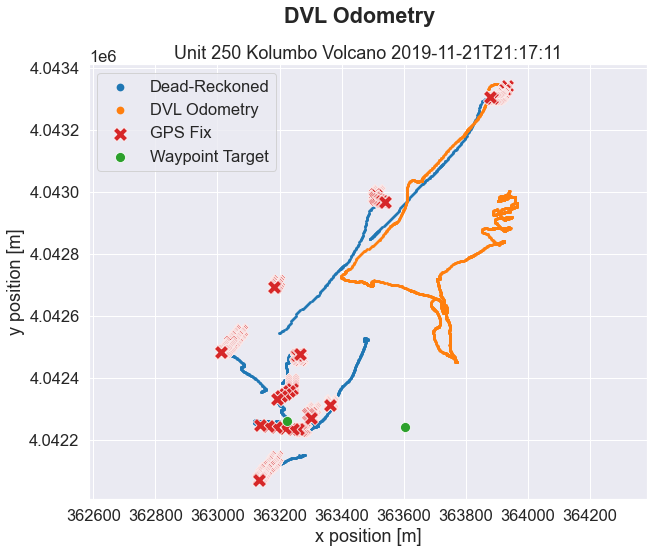

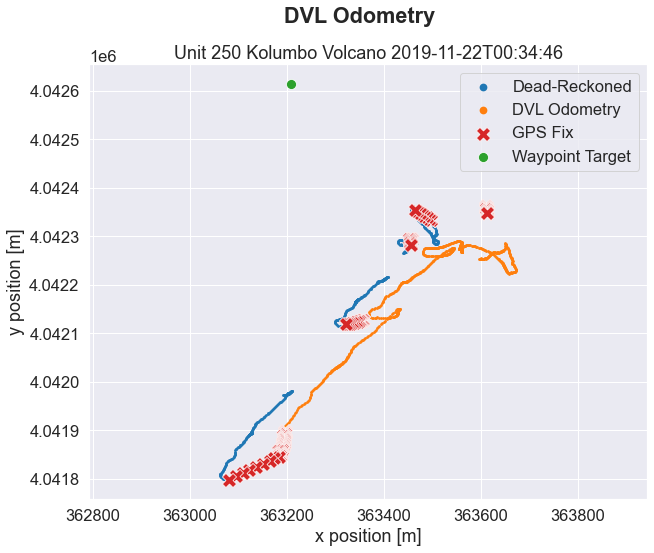

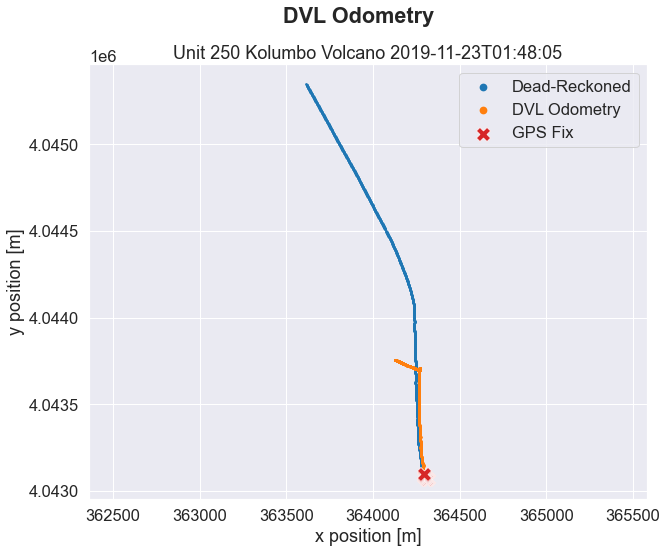

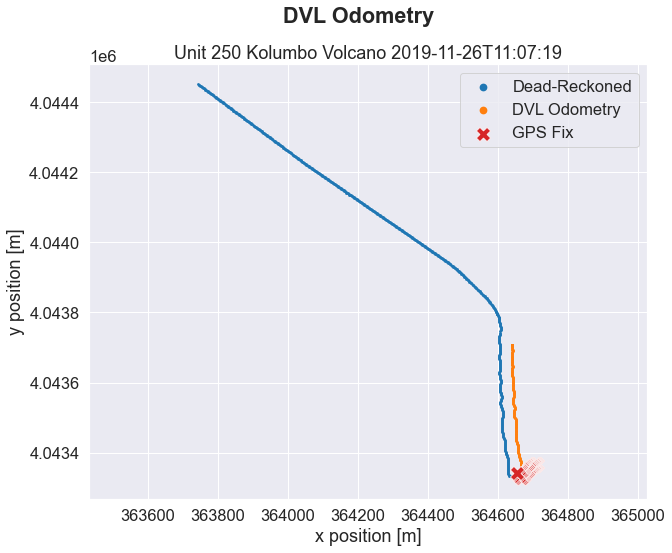

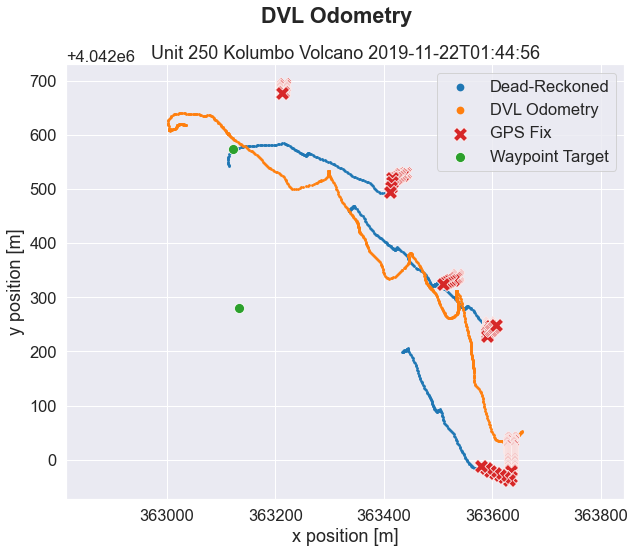

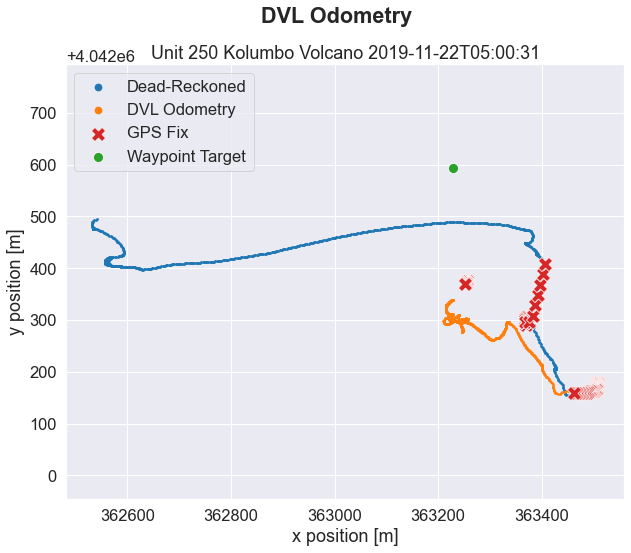

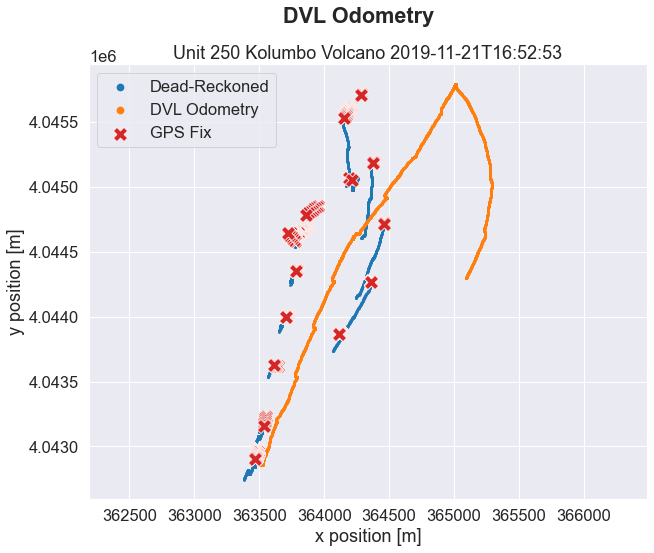

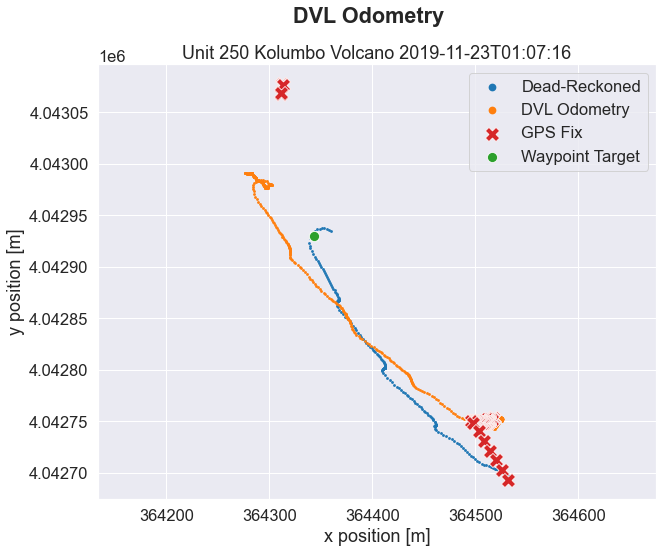

In [46]:
reload_modules()
SAVE = False
PLOT = True
glider      = "sentinel"
directory   = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-parsed/%s/" % glider
file_list   = [f for f in listdir(directory) if 
               isfile(join(directory,f)) and f.split('.')[-1] == 'CSV' and 
               len(f.split('_odometry')) != 2]

def get_utm_coords(m_lat, m_lon): 
    """TODO
    """
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)


# build dataframes for each odometry category 
dr_list  = []
odo_list = []
gps_list = []
wpt_list = []
all_list = []

# iterate through each dbd file and 
for f in file_list:
    SECS_IN_HOUR = 60*60
    SECS_IN_MIN  = 60
    df_pd0 = pd.read_csv(directory+f, header=0, index_col=0, parse_dates=True)
    start  = datetime.datetime.fromtimestamp(df_pd0.time[0])
    end    = datetime.datetime.fromtimestamp(df_pd0.time[-1])
    dur    = end - start 
    
    # sub-select a portion of glider flight computer variables
    df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
    print(f, "-------------------------")
    
    # extract first lat/lon gps position to use as origin
    for lat in df_dbd.m_gps_lat:
        if not np.isnan(lat):
            origin_m_lat = lat
            break
    origin_index = list(df_dbd.m_gps_lat).index(origin_m_lat)
    origin_m_lon = df_dbd.m_gps_lon[origin_index]
    origin_time  = datetime.datetime.fromtimestamp(df_dbd.time[origin_index])
    origin_hash  = df_dbd.m_filename_hash[origin_index]

    # convert to lat/lon coordinates to decimal fromat 
    origin_east,origin_north,origin_zone = get_utm_coords(origin_m_lat,origin_m_lon)
    
    # account for case when multiple dbd files span a single pd0 file
    print("    # dbd ensembles:  %d" % len(df_dbd))
    print("        # dbd files:  %d" % len(set(df_dbd.m_filename_hash)))
    print("         # missions:  %d" % len(set(df_dbd.m_mission_hash)))
    print("   input <lat, lon>: <%.2f, %.2f>" % (origin_m_lat, origin_m_lon))
    print("     UTM <  E,   N>: <%.2f, %.2f, zone=%d>\n\n" % (origin_east, origin_north, origin_zone))
    
    # extract positional offsets for the same moment in time
    sg2_x_offset = df_dbd[origin_time:].m_x_lmc[0]
    sg2_y_offset = df_dbd[origin_time:].m_y_lmc[0]
    dvl_x_offset = df_pd0[origin_time:].rel_pos_x[0]
    dvl_y_offset = df_pd0[origin_time:].rel_pos_y[0]

    # account for offsets in Glider and DVL file
    # TODO make this more SFB
    utm_dr_x  = df_dbd.m_x_lmc     - sg2_x_offset + origin_east
    utm_dr_y  = df_dbd.m_y_lmc     - sg2_y_offset + origin_north
    utm_dr_z  = df_dbd.m_depth 
    utm_gps_x = df_dbd.m_gps_x_lmc - sg2_x_offset + origin_east
    utm_gps_y = df_dbd.m_gps_y_lmc - sg2_y_offset + origin_north
    utm_wpt_x = df_dbd.c_wpt_x_lmc - sg2_x_offset + origin_east 
    utm_wpt_y = df_dbd.c_wpt_y_lmc - sg2_y_offset + origin_north 
    utm_odo_x = df_pd0.rel_pos_x   - dvl_x_offset + origin_east
    utm_odo_y = df_pd0.rel_pos_y   - dvl_y_offset + origin_north 
    utm_odo_z = df_pd0.rel_pos_z

    # collect data into indvidual DataFrames
    df_seg_dr = pd.DataFrame({
        'utm_dr_x' : utm_dr_x,
        'utm_dr_y' : utm_dr_y,
        'utm_dr_z' : utm_dr_z,
    })
    df_seg_gps = pd.DataFrame({
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
    })
    df_seg_odo = pd.DataFrame({
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,
    })
    df_seg_wpt = pd.DataFrame({
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
    })
    
    # add dataframes to running list 
    dr_list.append(df_seg_dr)
    odo_list.append(df_seg_odo)
    gps_list.append(df_seg_gps)
    wpt_list.append(df_seg_wpt)

    # convert data to pandas DataFrame
    frames = {
        'utm_dr_x'  : utm_dr_x,
        'utm_dr_y'  : utm_dr_y,
        'utm_dr_z'  : utm_dr_z,
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,    
    }
    df_all = pd.DataFrame(frames)
    all_list.append(df_all)
    
    # generate plots
    if PLOT:
        dvl_plotter.plot_odometry_and_dr(df_all, glider, '/Users/zduguid/Desktop/fig/%s.png' % f.split('.')[0])
    if SAVE:
        df_odo.to_csv('/Users/zduguid/Desktop/fig/%s.csv' % f.split('.')[0])

In [40]:
# # COMBINE FILES 
# df_dr_all  = pd.concat(dr_list)
# df_odo_all = pd.concat(odo_list)
# df_gps_all = pd.concat(gps_list)
# df_wpt_all = pd.concat(wpt_list)
# df_all_all = pd.concat(all_list)

# # PLOTTING
# sns.scatterplot(df_dr_all.utm_dr_x, df_dr_all.utm_dr_y)
# sns.scatterplot(df_wpt_all.utm_wpt_x, df_wpt_all.utm_wpt_y)
# sns.scatterplot(df_gps_all.utm_gps_x, df_gps_all.utm_gps_y)
# sns.scatterplot(df_odo_all.utm_odo_x, df_odo_all.utm_odo_y)

# # SAVING
# df_dr_all.to_csv('/Users/zduguid/Downloads/dr_all.csv')
# df_odo_all.to_csv('/Users/zduguid/Downloads/df_odo_all.csv')
# df_gps_all.to_csv('/Users/zduguid/Downloads/df_gps_all.csv')
# df_wpt_all.to_csv('/Users/zduguid/Downloads/df_wpt_all.csv')
# df_all_all.to_csv('/Users/zduguid/Downloads/all_fields_all_dives.csv')

---
## Plotting

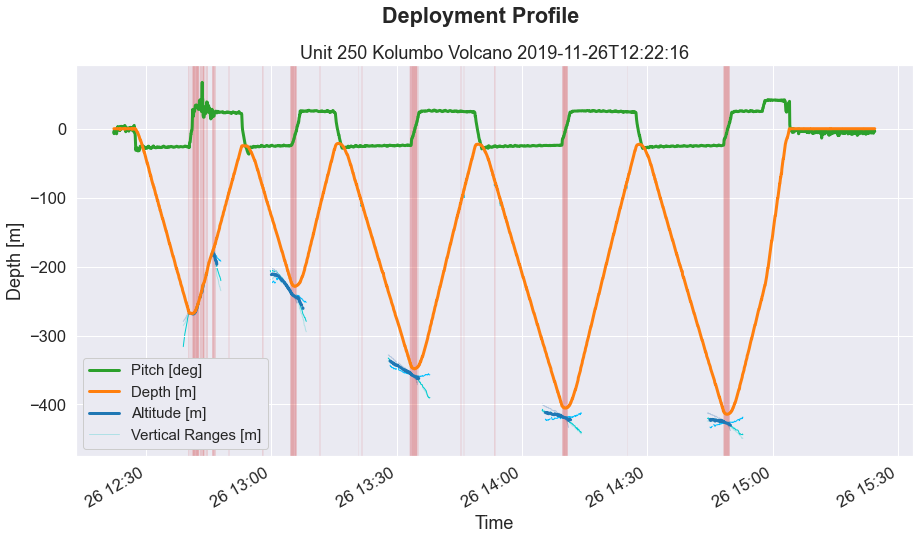

In [14]:
reload_modules()
glider = "sentinel"
dvl_plotter.plot_profile(ts, glider)